In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df=pd.read_csv('/content/drive/MyDrive/Mini Project/train.csv',encoding='ISO-8859-1')

In [5]:
df.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


In [6]:
df.drop('ItemID',axis=1)

,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...
...,...,...
99984,0,@Cupcake seems like a repeating problem hop...
99985,1,@cupcake__ arrrr we both replied to each other...
99986,0,@CuPcAkE_2120 ya i thought so
99987,1,@Cupcake_Dollie Yes. Yes. I'm glad you had mor...


In [7]:
word_index=pd.read_csv('/content/drive/MyDrive/Mini Project/word_indexes.csv')

In [8]:
word_index.head(10)

,Words,Indexes
0,tsukino,52009
1,nunnery,52010
2,sonja,16819
3,vani,63954
4,woods,1411
5,spiders,16118
6,hanging,2348
7,woody,2292
8,trawling,52011
9,hold's,52012


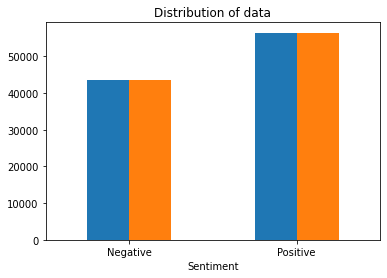

In [9]:
ax = df.groupby('Sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [10]:
contractions=pd.read_csv('/content/drive/MyDrive/Mini Project/contractions.csv')

In [11]:
contractions.index = contractions.index.astype(str).str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

import re
# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):
    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [12]:
df['processed_text'] = df.SentimentText.apply(preprocess_apply)

In [13]:
count=0
for row in df.itertuples():
    print("Text:", row[2])
    print("Processed:", row[3])
    count+=1
    if count>10:
        break

Text: 0
Processed:                      is so sad for my APL friend.............
Text: 0
Processed:                    I missed the New Moon trailer...
Text: 1
Processed:               omg its already 7:30 :O
Text: 0
Processed:           .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)...
Text: 0
Processed:          i think mi bf is cheating on me!!!       T_T
Text: 0
Processed:          or i just worry too much?        
Text: 1
Processed:        Juuuuuuuuuuuuuuuuussssst Chillin!!
Text: 0
Processed:        Sunny Again        Work Tomorrow  :-|       TV Tonight
Text: 1
Processed:       handed in my uniform today . i miss you already
Text: 1
Processed:       hmmmm.... i wonder how she my number @-)
Text: 0
Processed:       I must think about positive..


In [14]:
processedtext = list(df['processed_text'])
data_pos = processedtext[56457:]
data_neg = processedtext[:43532]

In [15]:
!pip install WordCloud
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


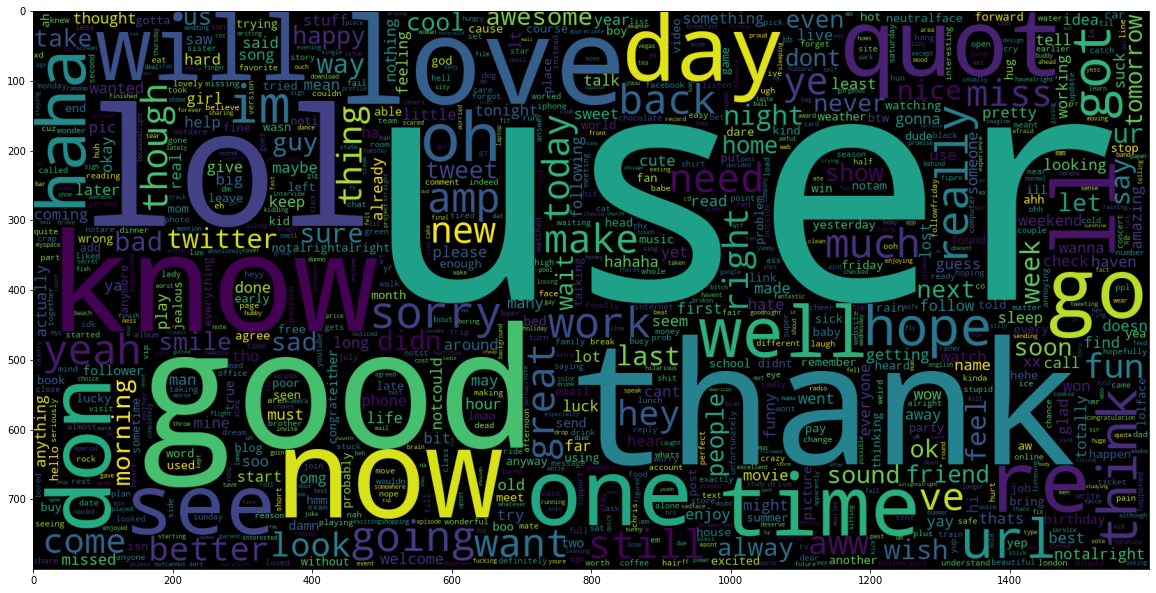

In [16]:
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

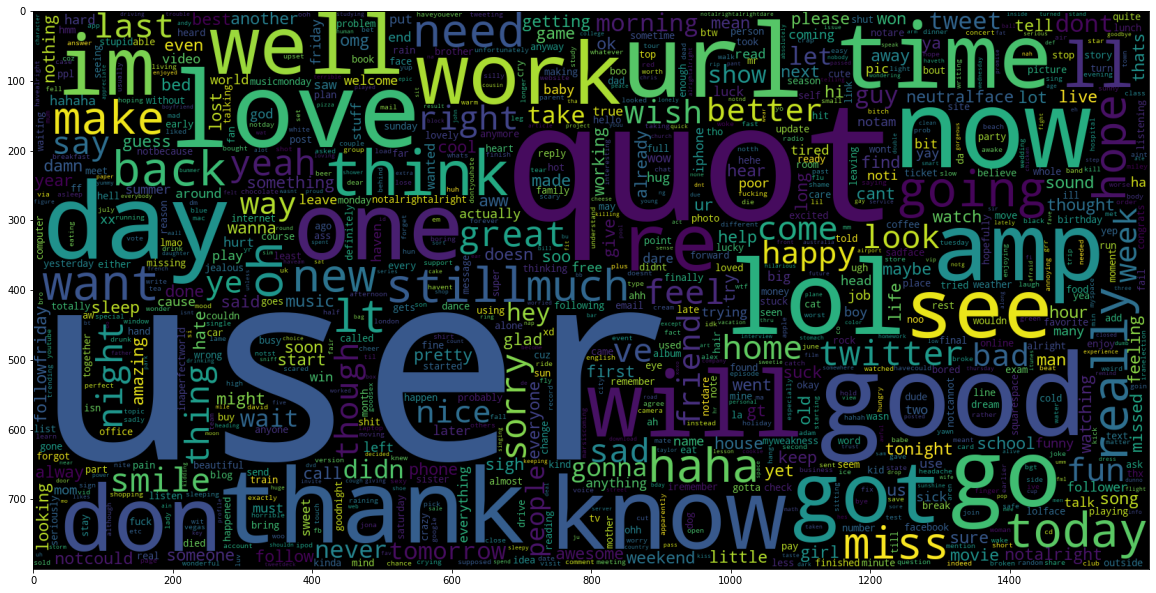

In [17]:
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_data, y_data = np.array(df['processed_text']), np.array(df['Sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = 0.05, random_state = 0)
print('Data Split done.')

Data Split done.


In [20]:
from gensim.models import Word2Vec

Embedding_dimensions = 100

# Creating Word2Vec training dataset.
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [21]:
word2vec_model = Word2Vec(Word2vec_train_data,
                 size=Embedding_dimensions,
                 workers=8,
                 min_count=5)

#print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

In [22]:
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [23]:
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 60000


In [24]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (94989, 60)
X_test.shape : (5000, 60)


In [25]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (60000, 100)


In [26]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [27]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")
    return model

In [28]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 100)           6000000   
                                                                 
 bidirectional (Bidirectiona  (None, 60, 200)          160800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 60, 200)          240800    
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 56, 100)           100100    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                   

In [29]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [30]:
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=7,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/7
84/84 [==============================] - 501s 6s/step - loss: 0.5682 - accuracy: 0.6976 - val_loss: 0.5355 - val_accuracy: 0.7228 - lr: 0.0010
Epoch 2/7
84/84 [==============================] - 490s 6s/step - loss: 0.5277 - accuracy: 0.7299 - val_loss: 0.5143 - val_accuracy: 0.7458 - lr: 0.0010
Epoch 3/7
84/84 [==============================] - 488s 6s/step - loss: 0.5135 - accuracy: 0.7419 - val_loss: 0.5052 - val_accuracy: 0.7480 - lr: 0.0010
Epoch 4/7
84/84 [==============================] - 485s 6s/step - loss: 0.5046 - accuracy: 0.7459 - val_loss: 0.4974 - val_accuracy: 0.7557 - lr: 0.0010
Epoch 5/7
84/84 [==============================] - 484s 6s/step - loss: 0.4945 - accuracy: 0.7532 - val_loss: 0.4903 - val_accuracy: 0.7580 - lr: 0.0010
Epoch 6/7
84/84 [==============================] - 488s 6s/step - loss: 0.4866 - accuracy: 0.7589 - val_loss: 0.4860 - val_accuracy: 0.7632 - lr: 0.0010
Epoch 7/7
84/84 [==============================] - 485s 6s/step - loss: 0.4828 - a

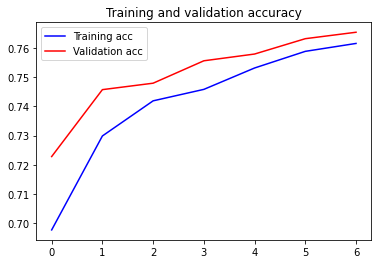

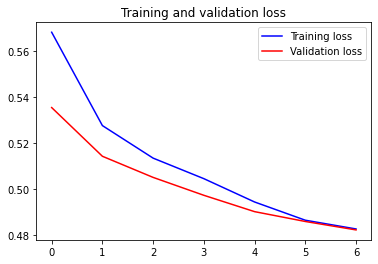

In [37]:
acc,  val_acc  = history.history['accuracy'], history.history['val_accuracy']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

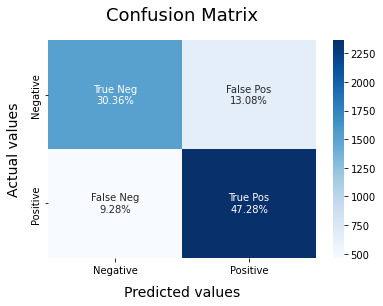

In [39]:
y_pred = training_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics.
import seaborn as sns 
ConfusionMatrix(y_pred, y_test)

In [41]:
print(accuracy_score(y_test,y_pred))

0.7764


In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.70      0.73      2172
           1       0.78      0.84      0.81      2828

    accuracy                           0.78      5000
   macro avg       0.77      0.77      0.77      5000
weighted avg       0.78      0.78      0.77      5000

